##Searching for Phenotypic Information with a Gene Name
by Colin Fletcher and Eileen Cahill

The International Mouse Phenotyping Consortium makes knockout mice, phenotypes them, and disseminates the data from www.impc.org.
Searching the website to find data for a specific gene is somewhat cumbersome and a script to quickly return phenotype data for a gene would be useful.

The first code cell checks the validity of the user input based on the fact that gene symbols are alphanumeric only and have no whitespace. 
Second, after a search using the API for the website, the error checking detects cases where the gene KO has not been phenotyped yet (~50% of genes).


In [11]:

import matplotlib.pyplot as plt
import seaborn as sns


while True:
    marker_symbol = input("Please enter a gene symbol: ")
    if any(x.isspace() for x in marker_symbol):
        print("No spaces allowed, please re-enter.")
        continue

    if not all(x.isalnum() for x in marker_symbol):
        print("Alphanumeric only please.")
        continue

    import pandas as pd
    CSV_URL = "https://www.ebi.ac.uk/mi/impc/solr/genotype-phenotype/select?q=marker_symbol:" + marker_symbol + "&rows=500&wt=csv&indent=1"
    df = pd.read_csv(CSV_URL)

    if df.empty:
        print("Looks like that gene doesn't have available information. Try another gene or check your cAsE.")
        continue
    else:
        break
        

The name of the gene found is presented for confirmation.
Phenotypes based on continuous data are selected, and the list is presented to the user.


In [12]:
AlleleFound = pd.unique(df['allele_symbol']).tolist()
AlleleFound = str(AlleleFound)
print("IMPC found this allele: " + AlleleFound)

df = df.dropna(subset=['percentage_change'])
mp_term_list = pd.unique(df['mp_term_name']).tolist()
print(mp_term_list)


IMPC found this allele: ['Fbxo7<tm1a(EUCOMM)Wtsi>']
['decreased circulating alanine transaminase level', 'decreased hematocrit', 'decreased erythrocyte cell number', 'decreased hemoglobin content', 'increased monocyte cell number', 'decreased leukocyte cell number', 'increased mean platelet volume', 'increased NK cell number', 'decreased NK T cell number', 'decreased CD8-positive, alpha-beta T cell number', 'decreased CD4-positive, alpha beta T cell number', 'decreased circulating fructosamine level', 'increased red blood cell distribution width', 'decreased T cell number', 'increased effector memory CD8-positive, alpha-beta T cell number', 'increased effector memory CD4-positive, alpha-beta T cell number', 'increased mean corpuscular hemoglobin', 'increased circulating bilirubin level', 'decreased circulating iron level', 'thrombocytosis']


The user inputs a phenotype term from the presented list in order to then retrieve the associated experimental data using the API for the website. 
This user input is error checked.
Some of the associated parameters are printed for confirmation. These will be used to retrieve data through the website API.


In [13]:
while True:
    PhenoTerm = input("Select a phenotype for analysis:  ")

    if not all(i.isalnum() for i in marker_symbol):
        print("Alphanumeric only please.")
        continue

    if PhenoTerm not in mp_term_list:
        print("Looks like you didn't enter a correct phenotype. Try again.")
        continue
    
    else:
        break

ParamId4Query = df.loc[df['mp_term_name'] ==  PhenoTerm, "parameter_stable_id"].iloc[0]
ColonyId4Query = df.loc[df['mp_term_name'] ==  PhenoTerm, "colony_id"].iloc[0]
print("Parameter Stable ID: " + ParamId4Query)
print("Colony ID: " + ColonyId4Query)


Parameter Stable ID: IMPC_HEM_004_001
Colony ID: MEBV



The code retrieves experimental and control data in 2 searches and the returned dataframes are concatenated.
The data set is grouped by control and KO, and by sex, and the mean is calculated.


In [7]:
CSV2_URL =  "https://www.ebi.ac.uk/mi/impc/solr/experiment/select?q=parameter_stable_id:"+ ParamId4Query +"%20AND%20colony_id:" + ColonyId4Query + "&rows=500&wt=csv&indent=true"
df2 = pd.read_csv(CSV2_URL) # this is KO data

MetadataGroupID = df2['metadata_group'].iloc[0]
PhenoCenterID = df2['phenotyping_center'].iloc[0]
ControlDataURL = "https://www.ebi.ac.uk/mi/impc/solr/experiment/select?q=parameter_stable_id:" + ParamId4Query + "&wt=csv&fq=metadata_group:" + MetadataGroupID + "&fq=phenotyping_center:" + PhenoCenterID + "&fq=strain_accession_id:%22MGI:2159965%22&fq=biological_sample_group:control&rows=100"
df3 = pd.read_csv(ControlDataURL) # this is wildtype data

frames = [df2, df3]
df4 = pd.concat(frames)
#the strings in the date column are converted into datetime objects
df4['datetime_for_experiment'] = pd.to_datetime(df4['date_of_experiment'], format = '%Y-%m-%dT%H:%M:%S')

sampletype = df4.groupby(['biological_sample_group', 'sex'])[['data_point']].mean()
print(sampletype)


                                data_point
biological_sample_group sex               
control                 female   54.667500
                        male     52.661765
experimental            female   47.784286
                        male     46.252857


Data is first plotted in a scatter plot to see the results over time.
The mean for the groups is then presented in a column plot. 


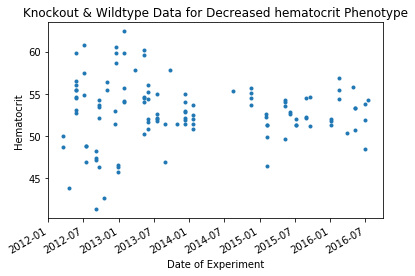

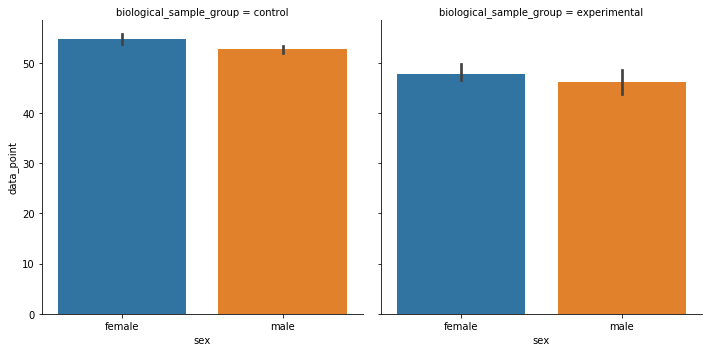

In [14]:
param = df4.loc[df4['parameter_stable_id'] == ParamId4Query, 'parameter_name'].iloc[0]
ax = df4.plot(x='datetime_for_experiment', y='data_point', style=".", legend = "", title= "Knockout & Wildtype Data for " + PhenoTerm.capitalize() + " Phenotype")
ax.set(xlabel='Date of Experiment', ylabel=param )

sns.catplot(x = 'sex', y = 'data_point', col = 'biological_sample_group', kind = 'bar', data=df4)
plt.show()

